In [1]:
import re, string, unicodedata
import numpy as np
import pandas as pd
import time

pd.set_option('display.max_colwidth', 40)

In [2]:
import contractions
import nltk
from datetime import datetime
from matplotlib import pyplot as plt

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, \
    cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laroc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\laroc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laroc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laroc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Perfilamiento y entendimiento de datos

## 1. Lectura de datos

cargamos el documento "fake_news_spanish.csv" para analizar cuantas filas y columnas tiene

In [3]:
train_set = "fake_news_spanish.csv"
df = pd.read_csv(train_set, sep=';', encoding='utf-8')

print(df.shape)
df.head(3)

(57063, 5)


,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster so...,El valencianismo convoca en Castelló...,25/04/2022


## 2. Entendimiento de datos

Debido a que el proyecto no contaba con un diccionario de datos se opto por desarrollar uno propio para la entrega. En el diccionario de datos, documento que también se encuenta en la raiz del proyecto, se detallan las siguientes descripciones:

| Columna | Descripción |
| - | - |
| `ID` | Contiene el identificador del registro, sin embargo, todos los registros tienen la cadena ID. |
| `Label` | Es la etiqueta del registro; 1 si el registro es una noticia falsa, 0 de lo contrario.  |
| `Titulo` | Corresponde al titulo de la noticia. |
| `Descripcion` | Corresponde a la descripción o el cuerpo de la noticia. |
| `Fecha` | Es la fecha en la que se publico la noticia. |

Para saber que columnas tiene el archivo usamos esta linea de codigo, asi podremos identificar con cual trabajaremos

In [4]:
df.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

In [5]:
df.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster so...,El valencianismo convoca en Castelló...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC...","En política, igual que hay que negoc...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna traged...,"En una entrevista en El Punt Avui, e...",09/03/2018


Al revisar la distribución de noticias catalogadas como falsas y no falsas notamos que este sigue una buena distribución, es decir, se tiene buena cantidad de ambas clases de noticias. Cerca del 60% de los registros son noticias falsas, mientras que aproximadamente el 40% de no lo son. 

In [6]:
df["Label"].value_counts() / df.shape[0] * 100

Label
1    58.107706
0    41.892294
Name: count, dtype: float64

Esto se puede ver mejor en la siguiente gráfica.

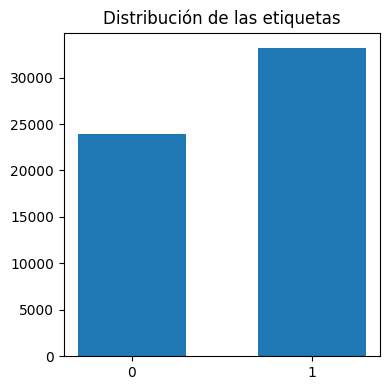

In [7]:
fig, axis = plt.subplots(1, figsize=(4,4), tight_layout=True)
axis.hist(df["Label"], bins=[-0.5, 0.5, 1.5], rwidth=0.6)
axis.set_xticks([0, 1])
plt.title('Distribución de las etiquetas')
plt.show()

Luego, se calculan las siguientes columnas para intentar hallar una relación entre estos estadisticos y las noticias falsas.

In [8]:
copy = df.copy()

copy["Count"] = [len(text) for text in copy["Descripcion"]] # Cantidad de caracteres en el registro
copy["Max"] = [max([len(word) for word in text.split(' ')]) for text in copy["Descripcion"] ] # Longitud de la palabra mas larga en el registro
copy["Min"] = [min([len(word) for word in text.split(' ')]) for text in copy["Descripcion"] ] # Longitud de la palabra mas corta en el registro
copy["Mean"] = [np.mean([len(word) for word in text.split(' ')]) for text in copy["Descripcion"] ] # Promedio de longitud de la palabra en el registro

copy.head(3)

,ID,Label,Titulo,Descripcion,Fecha,Count,Max,Min,Mean
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023,218,13,1,5.083333
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,01/10/2023,3251,17,1,5.067164
2,ID,1,El 'Ahora o nunca' de Joan Fuster so...,El valencianismo convoca en Castelló...,25/04/2022,169,13,2,4.666667


Al realizar un análisis de los estadisticos de las noticias falsas y las que no lo son tal parece que no hay grandes diferencias entre una u otra. Por ejemplo, la media de caracteres en las noticias falsas difiere de tan solo 7 unidades de las noticias que no lo son, 240 y 247 respectivamente. Los otros estadisticos continuan con esta tendencia de similitud.

In [9]:
copy[copy["Label"] == 1][["Count", "Max", "Min"]].describe()

,Count,Max,Min
count,33158.000000,33158.000000,33158.000000
mean,240.385729,12.708245,1.171965
std,301.279710,2.102463,0.384403
min,33.000000,6.000000,0.000000
25%,169.000000,11.000000,1.000000
50%,218.000000,13.000000,1.000000
75%,257.000000,14.000000,1.000000
max,14019.000000,38.000000,3.000000


In [10]:
copy[copy["Label"] == 0][["Count", "Max", "Min"]].describe()

,Count,Max,Min
count,23905.000000,23905.000000,23905.000000
mean,247.697260,12.717005,1.156662
std,228.702697,2.151326,0.383756
min,35.000000,6.000000,0.000000
25%,176.000000,11.000000,1.000000
50%,226.000000,13.000000,1.000000
75%,278.000000,14.000000,1.000000
max,13647.000000,69.000000,3.000000


### 2.1 Calidad de datos

En esta sección se hará un análisis de calidad de datos.

### 2.1.1 Unicidad

En esta parte se realiza la revisión de los duplicados y se soluciona de una vez. Se eliminan registros cuyas columnas son iguales. Además, es necesario mencionar que la columna ID solo contiene la cadena "ID". Por lo cual no es útil y se opta por eliminar esta columna.

In [11]:
copy.drop('ID', axis=1, inplace=True)
copy = df.copy()

copy[copy.duplicated()].shape

(445, 5)

In [12]:
copy.drop_duplicates(keep='first', inplace=True)
copy.head(2)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,01/10/2023


Al revisar los titulos y las descripciones duplicadas por separado obtenemos que hay cerca 5000 titulos duplicados y cerca de 7000 descripciones duplicadas. En los siguientes dos bloques de código se realiza un análisis de la distribución de las etiquetas, lo que nos lleva a concluir que las noticias duplicadas no tienden a ser mas falsas que las que no. Por otro lado, no es tan raro pensar en noticias con titulos duplicados, por tanto, se opta por dejar estas. Lo cual no lleva a centrar nuestra atención es las noticias con descripciones iguales. 

In [13]:
copy[copy.duplicated('Titulo')]["Label"].value_counts()

Label
0    2596
1    2417
Name: count, dtype: int64

In [14]:
copy[copy.duplicated('Descripcion')]["Label"].value_counts()

Label
0    3603
1    3377
Name: count, dtype: int64

En cuanto a las noticias con descripciones duplicadas se opta por eliminarlas del dataset para que las palabras en esas descripciones no tengan mas peso que las demás y de esta manera no se genere sesgo en el modelo.

In [15]:
copy.drop_duplicates('Descripcion', keep='first', inplace=True)
copy.shape

(49638, 5)

### 2.1.2 Completitud

En esta parte se realiza el análisis de completitud, en el cual se nota que hay algunos titulos que estan en NaN. Por lo tanto, es opta por agregar a estos 16 registros la primera oración de la descripción, hasta donde haya un punto.

In [16]:
copy.isna().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [17]:
# solución de la completitud
copy \
    .loc[copy["Titulo"].isna(), "Titulo"] = copy["Descripcion"] \
    .apply(lambda t: t.strip().split(".")[0] if isinstance(t, str) else t)

copy.isna().sum()

ID             0
Label          0
Titulo         0
Descripcion    0
Fecha          0
dtype: int64

### 2.1.3 Validez

En la siguiente linea de código se hace la conversión de la columna fecha a una fecha a un tipo de dato. Luego de esto, se revisa si hay valores nulos, puesto que si hay una fecha en un formato que no es apropiado se marca como `NaT`. Como se puede ver no hay fechas con formatos que no correspondan debido a lo anteriormente mencionado.

In [18]:
copy["formated_date"] = pd.to_datetime(copy["Fecha"], format="%d/%m/%Y", errors="coerce")

copy.isna().sum()

ID               0
Label            0
Titulo           0
Descripcion      0
Fecha            0
formated_date    0
dtype: int64

En la columna Label solo debe haber `0` o `1`, esto se verifica en la siguiente celda.

In [19]:
copy["Label"].value_counts()

Label
1    29361
0    20277
Name: count, dtype: int64

Se realiza un análisis de todos los titulos para comprobar si una de las palabras mas usadas en ingles se incluye en el titulo. Al realizar la transformación se obtiene que hay 37 registros con esta palabra y al revisar mas detalladamente se llega a la conclusión de que las noticias pueden tener palabras en ingles, pero en su totalidad el dataset no tiene la palabra en ingles "The", indicando la posibilidad de que este sea completamente en español. Nos quedaremos con este supuesto por facilidad. 

In [20]:
def detectar_idioma(texto):
    words = ["The", "The ", " the "]
    for word in words:
        if word in texto:
            return "unk"
    return "es"

copy["Idioma"] = copy["Titulo"].apply(detectar_idioma)

In [21]:
print(copy["Idioma"].value_counts())

Idioma
es     49601
unk       37
Name: count, dtype: int64


En la siguiente linea se revisan aquellas filas que estan marcadas con `unk`, al revisar rapidamente los titulos y las descripciones notamos que estas estan en español solo que incluyen, por ejemplo, nombres de peliculas. Para no hacer el cuaderno mas grande optamos por tomar solo los primeros 5 registros de los 37 que mencionamos. 

In [22]:
copy[copy["Idioma"] == 'unk'].head(5)

,ID,Label,Titulo,Descripcion,Fecha,formated_date,Idioma
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023,2023-06-02,unk
308,ID,1,La Guardia Civil incluye un 'off the...,El instituto armado se hace eco de l...,04/06/2020,2020-06-04,unk
1752,ID,1,Yolanda Díaz 'on the highway',"Bien podría ser una metáfora, bien p...",23/07/2022,2022-07-23,unk
3038,ID,1,'The New York Times' da voz a quiene...,Un reportaje refleja el descontento ...,08/04/2019,2019-04-08,unk
4281,ID,1,La revista 'The Lancet' señala que l...,El editorial de la prestigiosa revis...,17/10/2020,2020-10-17,unk


In [23]:
copy.drop(['Idioma', 'Fecha'], axis=1, inplace=True)
copy.columns

Index(['ID', 'Label', 'Titulo', 'Descripcion', 'formated_date'], dtype='object')

### 2.1.4 Consistencia

Se debe verificar que no tengamos noticias mayores al año 2026. Adicionalmente revisamos las fechas de las noticias, para saber si cumplen con los estandares planteados anteriormente en el diccionario.

In [24]:
today = datetime.today()
copy[copy["formated_date"] > today].shape

(0, 5)

In [25]:
copy['Año'] = copy['formated_date'].dt.year

copy.head(3)

,ID,Label,Titulo,Descripcion,formated_date,Año
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,2023-06-02,2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,2023-10-01,2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster so...,El valencianismo convoca en Castelló...,2022-04-25,2022


En el siguiente codigo se verifica si para una misma descripción se cuentan con mas de dos labels diferentes, esto para evitar inconsistencias.  

In [26]:
label_conflicto = copy.groupby("Descripcion")["Label"].nunique()
print(label_conflicto[label_conflicto > 1])

Series([], Name: Label, dtype: int64)


# 3. Preparación de datos

En esta fase se hará un proceso de tres etapas:

1. Limpieza de datos
2. Tokenización
3. Normalización

Antes de realizar todo esto se opta por rechazar la columna de la fecha en la que fue publicada la noticia. Esto debido a que al usar la fecha para predecir si una noticia es falsa es una mala idea porque no tiene una relación causal con la veracidad y puede generar sobreajuste si el modelo aprende patrones específicos de ciertos períodos de tiempo. Además, introduce un sesgo temporal, ya que eventos como elecciones o crisis pueden afectar la cantidad de noticias falsas, haciendo que el modelo no generalice bien a datos futuros. También, la fecha por sí sola no aporta información semántica relevante sobre la credibilidad del contenido, por lo que es mejor enfocarse en características como el título, la descripción y el cuerpo de la noticia.

## 3.1 Limpieza de datos

Se completan las siguientes funciones para eliminar los caracteres no ASCII, convertir en minuscula los textos, eliminar la puntuación, reemplazar los números y eliminar los stopwords. Esto se unifica en la función `preprocessing`.

In [27]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def replace_numbers(words):
   """Replace all interger occurrences in list of tokenized words with textual representation"""
   p = inflect.engine()
   new_words = []
   for word in words:
       if word.isdigit():
           new_word = p.number_to_words(word)
           new_words.append(new_word)
           #print("if " + new_word)
       else:
           new_words.append(word)
   return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = set(stopwords.words('spanish'))  # Cargar stopwords en español
    return [word for word in words if word not in stop_words]

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

## 3.2 Tokenización

Primero que todo se expanden las constracciones, lo cual solo requiere expandir "al" y "del" debido a que son las contracciones mas comunes en español.

In [28]:
def expand_spanish_contractions(text):
    text = text.replace("al", "a el")
    return text.replace("del" ,"de el")

copy['Descripcion'] = copy['Descripcion'].apply(expand_spanish_contractions)
copy['Titulo'] = copy['Titulo'].apply(expand_spanish_contractions)

copy[['Descripcion', 'Titulo']].head(2)

,Descripcion,Titulo
0,El diario británico publicó este pas...,'The Guardian' va con Sánchez: 'Euro...
1,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...


Ahora, se aplica la tokenización de las columnas Descripcion y Titulo. 

In [29]:
copy['tokenized_desc'] = copy['Descripcion'].apply(word_tokenize)
copy['tokenized_titl'] = copy['Titulo'].apply(word_tokenize)

copy[['tokenized_desc', 'tokenized_titl']].head(3)

,tokenized_desc,tokenized_titl
0,"[El, diario, británico, publicó, est...","['The, Guardian, ', va, con, Sánchez..."
1,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO...","[REVELAN, QUE, EL, GOBIERNO, NEGOCIO..."
2,"[El, va, elencianismo, convoca, en, ...","[El, 'Ahora, o, nunca, ', de, Joan, ..."


Una vez se realiza la tokenización se aplica el preprocesamiento antes mencionado.

In [30]:
copy['tokenized_desc'] = copy['tokenized_desc'].apply(preprocessing)
copy['tokenized_titl'] = copy['tokenized_titl'].apply(preprocessing)

copy[['Descripcion', 'tokenized_desc', 'Titulo', 'tokenized_titl']].head(3)

,Descripcion,tokenized_desc,Titulo,tokenized_titl
0,El diario británico publicó este pas...,"[diario, britanico, publico, pasado,...",'The Guardian' va con Sánchez: 'Euro...,"[the, guardian, va, sanchez, europa,..."
1,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,"[revelan, gobierno, negocio, liberac...",REVELAN QUE EL GOBIERNO NEGOCIO LA L...,"[revelan, gobierno, negocio, liberac..."
2,El va elencianismo convoca en Castel...,"[va, elencianismo, convoca, castello...",El 'Ahora o nunca' de Joan Fuster so...,"[ahora, nunca, joan, fuster, estatut..."


## 3.3 Normalización

En la siguiente celda de código se realiza la normalización de las palabras utilizando `LancasterStemmer()` y `WordNetLemmatizer()`. Esto para aplicar la lematización y la eliminación de prefijos y sufijos.

In [31]:
stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_words(words):
    """Stem words in list of tokenized words"""
    return [stemmer.stem(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    return [lemmatizer.lemmatize(word, pos='v') for word in words]

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

In [32]:
copy['normalized_desc'] = copy['tokenized_desc'].apply(stem_and_lemmatize)
copy['normalized_titl'] = copy['tokenized_titl'].apply(stem_and_lemmatize)

También se intento hacer esto mismo con otra libreria especializada en español, pero el tiempo que demora en ejecutarse el siguiente bloque de código es demasiado en comparación al otro. El rendimiento del modelo no mejora al utilizar esta libreria, por lo tanto, se opta por no utilizarse. 

In [33]:
# import pandas as pd
# import spacy
# import nltk
# from nltk.stem import SnowballStemmer

# nlp = spacy.load("es_core_news_sm")
# # Inicializar el stemmer en español
# stemmer = SnowballStemmer('spanish')

# def stem_and_lemmatize_batch(texts):
#     """Optimiza la lematización y stemming usando spaCy y Snowball en batch"""
#     docs = list(nlp.pipe(texts))  # Procesa en batch
#     results = []
#     for doc in docs:
#         stems = [stemmer.stem(token.text) for token in doc]
#         lemmas = [token.lemma_ for token in doc]
#         results.append(stems + lemmas)  # Combina ambos
#     return results

# # Aplicar el procesamiento en batch
# copy['normalized'] = stem_and_lemmatize_batch(copy['tokenized_desc'].apply(lambda x: ' '.join(x)))

## 3.4 Selección de campos

En esta parte se realiza la unión de las listas de palabras normalizadas para tener una cadena de todas las palabras.

In [34]:
copy['desc_words'] = copy['normalized_desc'].apply(lambda x: ' '.join(map(str, x)))
copy['titl_words'] = copy['normalized_titl'].apply(lambda x: ' '.join(map(str, x)))

In [35]:
copy[['desc_words', 'normalized_desc', 'titl_words', 'normalized_titl']].head(3)

,desc_words,normalized_desc,titl_words,normalized_titl
0,diario britanico publico pasado juev...,"[diario, britanico, publico, pasado,...",the guard va sanchez europ necesit a...,"[the, guard, va, sanchez, europ, nec..."
1,revel gobierno negocio liberac mirel...,"[revel, gobierno, negocio, liberac, ...",revel gobierno negocio liberac mirel...,"[revel, gobierno, negocio, liberac, ..."
2,va elencianismo convoc castello fies...,"[va, elencianismo, convoc, castello,...",ahor nunc joan fust estatuto va elen...,"[ahor, nunc, joan, fust, estatuto, v..."


In [36]:
X_data, y_label = copy[['desc_words', 'titl_words']], copy['Label']
print(X_data.shape, y_label.shape)

(49638, 2) (49638,)


In [37]:
tf_idf = TfidfVectorizer()

X_words = X_data['desc_words'] + ' ' + X_data['titl_words']

X_combined = pd.concat([X_words, X_data[['desc_words', 'titl_words']]], axis=1)
X_combined.columns = ['combined', 'desc_words', 'titl_words']

X_tf_idf = tf_idf.fit_transform(X_combined['combined'])

In [38]:
X_tf_idf.shape

(49638, 66495)

# 4. Creación del pipeline de preprocesamiento

En este Pipeline se incluye

1. Eliminar los duplicados.
2. ELIMINAR FILA SI la descripción es None (df.dropna(subset=['Descripcion'])
2. Eliminar descripciones duplicadas.
3. Para los títulos vacíos hacemos una imputación.
4. Expandir las contracciones
5. Word_tokenize
6. Preprocessing
7. Normalizar
8. Selección de campos, unirlos
9. Unir campos en uno solo
10. Devolver una matriz dispersa con las características


In [39]:
def remove_duplicates(df):
    print('status: eliminado duplicados')
    return df.drop_duplicates(keep='first')

def remove_duplicates_desc(df):
    print('status: eliminado descripciones duplicados')
    return df.drop_duplicates('Descripcion', keep='first', inplace=False)

def empty_title(df):
    print('status: imputando titulos')
    df \
        .loc[df["Titulo"].isna(), "Titulo"] = df["Descripcion"] \
        .apply(lambda t: t.strip().split(".")[0] if isinstance(t, str) else t)
    
    return df

def expand_contractions(df):
    print('status: contracciones')
    df['Descripcion'] = df['Descripcion'].apply(expand_spanish_contractions)
    df['Titulo'] = df['Titulo'].apply(expand_spanish_contractions)
    return df

def tokenize(df):
    print('status: tokenizar')
    df['tokenized_desc'] = df['Descripcion'].apply(word_tokenize)
    df['tokenized_titl'] = df['Titulo'].apply(word_tokenize)
    return df

def clean_noise(df):
    print('status: preprocessing functions')
    df['tokenized_desc'] = df['tokenized_desc'].apply(preprocessing)
    df['tokenized_titl'] = df['tokenized_titl'].apply(preprocessing)
    return df

def normalize(df):
    print('status: normalizar')
    df['normalized_desc'] = df['tokenized_desc'].apply(stem_and_lemmatize)
    df['normalized_titl'] = df['tokenized_titl'].apply(stem_and_lemmatize)
    return df

def feature_sel(df):
    print('status: unir palabras ')
    df['desc_words'] = df['normalized_desc'].apply(lambda x: ' '.join(map(str, x)))
    df['titl_words'] = df['normalized_titl'].apply(lambda x: ' '.join(map(str, x)))
    return df

def gen_sparse_matrix(df, fit_vectorizer):
    print('status: finalizando (seleccionando caracteristicas)')
    X_data = df[['desc_words', 'titl_words']]

    X_words = X_data['desc_words'] + ' ' + X_data['titl_words']

    # X_combined = pd.concat([X_words, X_data[['desc_words', 'titl_words']]], axis=1)
    # X_combined.columns = ['combined', 'desc_words', 'titl_words']

    if fit_vectorizer:
        X_tf_idf = tf_idf.fit_transform(X_words)  # Ajustar y transformar en entrenamiento
    else:
        X_tf_idf = tf_idf.transform(X_words)

    return X_tf_idf

def transform_pipeline(df, fit_vectorizer=False):
    df = remove_duplicates(df)
    df = remove_duplicates_desc(df)
    df = empty_title(df)
    df = expand_contractions(df)
    df = tokenize(df)
    df = clean_noise(df)
    df = normalize(df)
    df = feature_sel(df)
    X_tf_idf = gen_sparse_matrix(df, fit_vectorizer)
    return X_tf_idf

# 5. Entrenamiento de los modelos

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tf_idf,
    y_label,
    test_size=0.3,
    random_state=42
)

## 5.1 Regresión logistica (Javier Barrera)

Es un modelo estadístico utilizado para la clasificación binaria, basado en la función sigmoide para estimar la probabilidad de que una observación pertenezca a una de dos categorías. Es simple, eficiente y útil cuando las relaciones entre variables son aproximadamente lineales. Seleccionamos este modelo porque es simple y eficiente para problemas de clasificación binaria como la detección de noticias falsas. Además, su interpretabilidad permite entender la contribución de cada característica en la predicción, lo que facilita la toma de decisiones basada en datos.

En las siguientes dos celdas se hace el entrenamiento de regresión logistica y una validación utilizando validación cruzada, el modelo tiene un muy buen puntaje `f1`, por encima de 90%.

In [42]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [43]:
scores = cross_val_score(model, X_test, y_test, cv=5, scoring='f1')

print(scores)
scores.mean()

[0.91568837 0.9064482  0.90407359 0.89936776 0.90174326]


0.9054642355330793

El modelo presenta una precisión de 0.96 para **la clase 0 (noticia no falsa)**, lo que indica que cuando predice que una noticia es real, acierta el 96% de las veces. Sin embargo, su recall es de 0.79, lo que significa que no detecta correctamente el 21% de las noticias reales, clasificándolas erróneamente como falsas. Esto sugiere que el modelo es más conservador al asignar la etiqueta de noticia real, lo que genera una cantidad considerable de falsos negativos. Por otro lado, para **la clase 1 (noticia falsa)**, la precisión es de 0.87, lo que implica que el 87% de las noticias identificadas como falsas realmente lo son, pero su recall es de 0.97, lo que significa que detecta casi todas las noticias falsas con muy pocos falsos negativos. Esto indica que el modelo está priorizando la detección de noticias falsas a costa de sacrificar algunos casos de noticias reales.

El F1-score de 0.86 para la clase 0 y 0.92 para la clase 1 muestra que el rendimiento global es más equilibrado para la detección de noticias falsas, mientras que la detección de noticias reales aún tiene margen de mejora en términos de recall.

In [44]:
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.79      0.86      6128
           1       0.87      0.97      0.92      8764

    accuracy                           0.90     14892
   macro avg       0.91      0.88      0.89     14892
weighted avg       0.90      0.90      0.90     14892



Lo anterior se puede visualizar mejor en el siguiente diagrama que presenta la matriz de confusión.

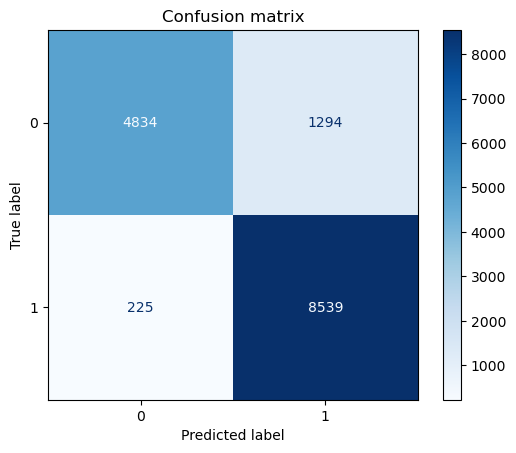

In [45]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=[0, 1]
)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

### 5.1.1. Obtener la importancia de las características

In [46]:
importance = np.abs(model.coef_)[0]
features = tf_idf.get_feature_names_out()

features

array(['0000', '00083', '001', ..., 'zulueta', 'zurekin', 'zurich'],
      dtype=object)

In [47]:
sorted_indices = np.argsort(importance)[::-1]
sorted_features = [features[i] for i in sorted_indices]
sorted_importance = importance[sorted_indices]

# Mostrar las características más importantes
for feat, imp in zip(sorted_features[:10], sorted_importance[:10]):
    print(f"{feat}: {imp}")

equo: 17.08339304462861
eajpnv: 14.115647255404562
bng: 13.905961621704726
per: 12.220731134676647
sanchez: 11.508210061005302
podemos: 10.249570414965048
podemo: 10.199628427817204
canaria: 9.559409969045499
erc: 9.1900709514612
casado: 7.953235567154132


### 5.1.2. Construcción del modelo con búsqueda de hiperparámetros

Ahora, se hara rapidamente un `Hyperparameter tunning` para intentar mejorar el modelo.

In [48]:
folds = KFold(n_splits=5, shuffle=True, random_state=0)

param_grid = {
    'class_weight': [{0: 1.2, 1: 0.8}],
    'penalty': ['l2'],
    'solver': ['sag']
}

param_grid

{'class_weight': [{0: 1.2, 1: 0.8}], 'penalty': ['l2'], 'solver': ['sag']}

In [49]:
log_reg = LogisticRegression()

best_log_reg = GridSearchCV(log_reg, param_grid, cv=folds)
best_log_reg.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'class_weight': [{0: 1.2, 1: 0.8}], 'penalty': ['l2'],
                         'solver': ['sag']})

In [50]:
best_log_reg.best_params_

{'class_weight': {0: 1.2, 1: 0.8}, 'penalty': 'l2', 'solver': 'sag'}

In [51]:
log_reg = best_log_reg.best_estimator_

Al realizar este proceso obtenemos una mejora en el puntaje f1, el cual aumenta en casi una unidad. Esto se verificará en seguida con el reporte de clasificación.

In [52]:
scores = cross_val_score(log_reg, X_test, y_test, cv=5, scoring='f1')

print(scores)
scores.mean()

[0.92324622 0.91282895 0.90983607 0.90220648 0.90739726]


0.9111029947589472

Después de realizar el ajuste de hiperparámetros con GridSearchCV, el modelo muestra una precisión de 0.92 para la **clase 0 (noticia no falsa)**, lo que significa que cuando predice que una noticia es real, acierta el 92% de las veces. Su recall ha mejorado a 0.83, lo que indica que ahora detecta mejor las noticias reales, reduciendo la cantidad de falsos negativos en comparación con la versión anterior del modelo.
En cuanto a la **clase 1 (noticia falsa)**, la precisión es de 0.89, lo que indica que el 89% de las predicciones de noticias falsas son correctas, mientras que el recall es de 0.95, lo que significa que el modelo sigue detectando la mayoría de las noticias falsas con pocos falsos negativos.

El F1-score para la clase 0 ha aumentado a 0.88, lo que indica un mejor equilibrio entre precisión y recall en la detección de noticias reales, y el F1-score para la clase 1 se mantiene en 0.92, lo que sugiere que el modelo sigue teniendo un buen rendimiento en la detección de noticias falsas. En general, la mejora en recall para la clase 0 implica que el modelo ahora tiene una menor tendencia a clasificar erróneamente noticias reales como falsas, lo que lo hace más equilibrado y robusto.

In [53]:
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.83      0.88      6128
           1       0.89      0.95      0.92      8764

    accuracy                           0.90     14892
   macro avg       0.91      0.89      0.90     14892
weighted avg       0.90      0.90      0.90     14892



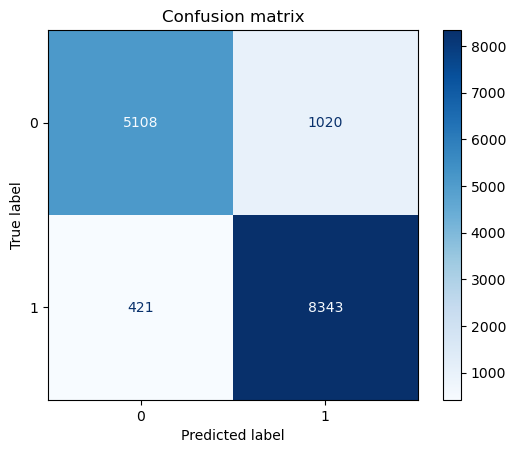

In [54]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_test),
    display_labels=[0, 1]
)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

## 5.2 Modelo XGBoost (Javier Barrera)

Un algoritmo de boosting basado en árboles de decisión, optimizado para rendimiento y velocidad. Utiliza técnicas como regularización y manejo eficiente de datos faltantes para mejorar la precisión en tareas de clasificación y regresión, siendo muy utilizado en competencias de Machine Learning. Debido a la capacidad de optimizacion y alto rendimiento en datos estructurados, seleccionamos este modelo. Su manejo eficiente de características, regularización para evitar sobreajuste y velocidad de entrenamiento lo hacen ideal para mejorar la precisión en la clasificación de noticias falsas.

In [108]:
from xgboost import XGBClassifier

In [109]:
model = XGBClassifier(objective='binary:logistic', random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [110]:
scores = cross_val_score(model, X_test, y_test, cv=5, scoring='f1')

print(scores)
scores.mean()

[0.94085282 0.9314395  0.92567384 0.92013982 0.92786885]


0.9291949656611486

El modelo de XGBoost ha logrado un rendimiento notablemente alto en términos de precisión, recall y F1-score para ambas clases. Para la **clase 0 (noticia no falsa)**, la precisión es de 0.97, lo que indica que la mayoría de las noticias clasificadas como no falsas son realmente verdaderas, mientras que el recall es de 0.85, lo que sugiere que aún hay margen de mejora en la detección de todas las noticias no falsas. En la **clase 1 (noticia falsa)**, la precisión es de 0.90 y el recall de 0.98, lo que significa que el modelo identifica casi todas las noticias falsas, aunque ocasionalmente puede clasificar incorrectamente algunas noticias verdaderas como falsas.

En general, el modelo obtiene un F1-score de 0.91 para la clase 0 y 0.94 para la clase 1, con una precisión y recall macro promedio de 0.94 y 0.92, respectivamente. A pesar de estos buenos resultados, un inconveniente importante es el tiempo de entrenamiento, ya que XGBoost es un modelo computacionalmente costoso, lo que puede hacer que la optimización sea un proceso lento.

In [111]:
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      6128
           1       0.90      0.98      0.94      8764

    accuracy                           0.93     14892
   macro avg       0.94      0.92      0.93     14892
weighted avg       0.93      0.93      0.93     14892



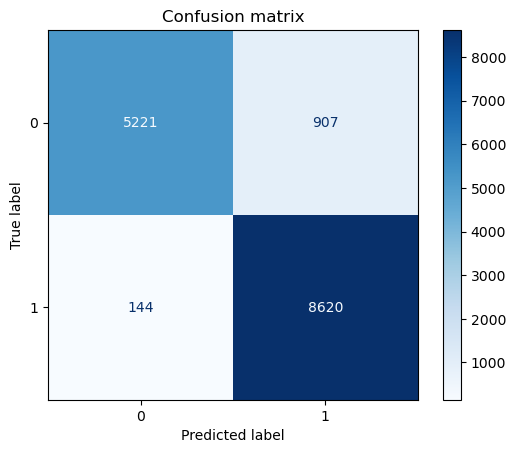

In [112]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=[0, 1]
)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

### 5.1.1 Obtener la importancia de las características

### 5.2.2 Construcción del modelo con búsqueda de hiperparámetros

In [118]:
folds = KFold(n_splits=4, shuffle=True, random_state=0)

param_distributions = {
    'n_estimators': [50, 70],
    'max_depth': [6, 7],
}

param_distributions

{'n_estimators': [50, 70], 'max_depth': [6, 7]}

En este caso se prefiere `RandomizedSearchCV` sobre `GridSearchCV` cuando el espacio de hiperparámetros es grande o el entrenamiento del modelo es costoso. Esto dado que `RandomizedSearchCV` prueba solo un subconjunto aleatorio de combinaciones, reduciendo el tiempo de cómputo. Todo esto ya que el entrenamiento de este modelo en particular es bastante lento. El siguiente código demora aproximadamente 7 minutos en terminar su ejecución.

In [120]:
xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    random_state=42
)

random_search = RandomizedSearchCV(
    xgb_classifier,
    param_distributions,
    scoring='f1',
    cv=folds,
    verbose=2,
    random_state=42,
    n_iter=4
)

random_search.fit(X_train, y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] END .......................max_depth=6, n_estimators=50; total time=  18.9s
[CV] END .......................max_depth=6, n_estimators=50; total time=  18.8s
[CV] END .......................max_depth=6, n_estimators=50; total time=  19.3s
[CV] END .......................max_depth=6, n_estimators=50; total time=  18.4s
[CV] END .......................max_depth=6, n_estimators=70; total time=  23.4s
[CV] END .......................max_depth=6, n_estimators=70; total time=  24.2s
[CV] END .......................max_depth=6, n_estimators=70; total time=  24.8s
[CV] END .......................max_depth=6, n_estimators=70; total time=  23.5s
[CV] END .......................max_depth=7, n_estimators=50; total time=  23.6s
[CV] END .......................max_depth=7, n_estimators=50; total time=  23.7s
[CV] END .......................max_depth=7, n_estimators=50; total time=  22.6s
[CV] END .......................max_depth=7, n_es

RandomizedSearchCV(cv=KFold(n_splits=4, random_state=0, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=Non...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=4,
                   param_distributions={'max_depth': [6, 7],
                                        'n_estimators': [50, 70]},
                   random_state=42, scoring='f1', verbose=2)

In [121]:
random_search.best_params_

{'n_estimators': 70, 'max_depth': 7}

In [122]:
xgb_model = random_search.best_estimator_

Después de aplicar `RandomizedSearchCV` en lugar del modelo base, se han obtenido métricas de rendimiento similares, con ligeras mejoras en algunos aspectos clave. Para la clase 0 (noticia no falsa), la precisión aumentó de 0.97 a 0.98, aunque el recall se mantuvo en 0.85, lo que indica una leve mejora en la precisión sin afectar la capacidad de detección. Para la clase 1 (noticia falsa), la precisión permaneció en 0.90, mientras que el recall mejoró de 0.98 a 0.99, lo que demuestra que el modelo XGBoost logra identificar aún mejor las noticias falsas con menos falsos negativos.

El F1-score para la clase 0 se mantuvo en 0.91, mientras que para la clase 1 permaneció en 0.94, lo que refleja un rendimiento estable en ambas clases. La precisión y recall promedio (macro avg) siguen en 0.94 y 0.92, respectivamente, mostrando que el modelo mantiene un equilibrio entre ambas clases. En conclusión, el cambio a XGBoost ha proporcionado mejoras menores en la precisión y recall sin comprometer el rendimiento global del modelo, aunque sigue siendo importante evaluar su costo computacional en comparación con el modelo original.

In [123]:
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      6128
           1       0.90      0.99      0.94      8764

    accuracy                           0.93     14892
   macro avg       0.94      0.92      0.93     14892
weighted avg       0.93      0.93      0.93     14892



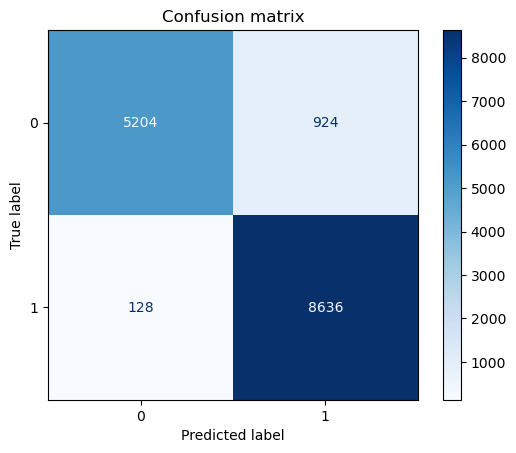

In [124]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_test),
    display_labels=[0, 1]
)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

## 5.3. Modelo RandomForest (Julián Rolón)

Un conjunto de múltiples árboles de decisión entrenados sobre subconjuntos de los datos, combinando sus predicciones para mejorar la precisión y reducir el sobreajuste. Es robusto, versátil y capaz de manejar datos con muchas características sin requerir una gran preparación previa. Elegimos este modelo por su robustez y capacidad para manejar datos con muchas variables sin requerir un preprocesamiento exhaustivo. Su combinación de múltiples árboles minimiza el sobreajuste y proporciona predicciones más estables, lo que lo convierte en una excelente opción para modelos de texto.

In [125]:
from sklearn.ensemble import RandomForestClassifier

In [126]:
randomF = RandomForestClassifier(n_estimators=30, random_state=42)
randomF.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30, random_state=42)

El modelo RandomForest presenta un desempeño sólido. Para la **clase 0 (noticias no falsas)**, la precisión es de 0.94, lo que indica que cuando el modelo predice una noticia como no falsa, en la mayoría de los casos, está en lo correcto. Sin embargo, el recall para esta clase es de 0.85, lo que sugiere que el modelo no identifica todas las noticias no falsas correctamente, perdiendo algunas en el proceso. Como resultado, el F1-score de esta clase es de 0.89, reflejando un balance aceptable entre precisión y recall. Para la **clase 1 (noticias falsas)**, el modelo obtiene una precisión de 0.90, lo que significa que cuando predice que una noticia es falsa, en la mayoría de los casos acierta. Además, el recall es bastante alto, con un valor de 0.96, lo que indica que el modelo es muy efectivo en identificar noticias falsas correctamente. Esto se traduce en un F1-score de 0.93, lo que confirma que el modelo maneja bien esta categoría.

En términos generales, la exactitud global del modelo es del 92%, lo que es un buen indicador de rendimiento. Sin embargo, un punto importante a considerar es que RandomForest es un modelo computacionalmente costoso. Esto puede representar un problema si se desea hacer iteraciones frecuentes para mejorar el modelo.

In [127]:
y_pred = randomF.predict(X_test)

print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      6128
           1       0.90      0.96      0.93      8764

    accuracy                           0.92     14892
   macro avg       0.92      0.91      0.91     14892
weighted avg       0.92      0.92      0.91     14892



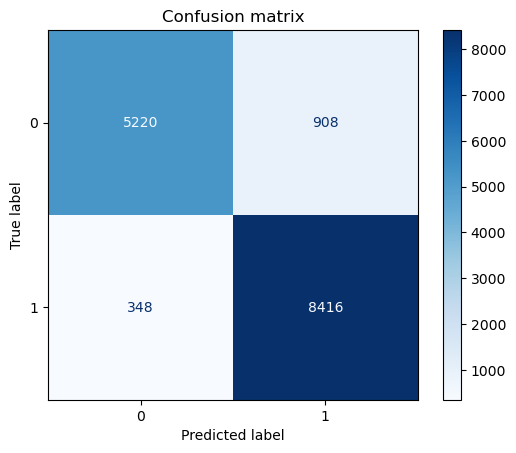

In [128]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=[0, 1]
)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

### 5.3.1 Obtener la importancia de las características

### 5.3.2 Construcción del modelo con búsqueda de hiperparámetros

In [133]:
folds = KFold(n_splits=3, shuffle=True, random_state=0)

param_distributions = {
    'n_estimators': [10, 50, 70],
    'max_depth': [6, None],
    #'min_samples_split': [2, 5]
}

param_distributions

{'n_estimators': [10, 50, 70], 'max_depth': [6, None]}

In [134]:
randomF = RandomForestClassifier(n_estimators=30, random_state=42)

random_search = RandomizedSearchCV(
    randomF, 
    param_distributions,
    scoring='f1', 
    cv=folds, 
    verbose=2, 
    random_state=42,
    n_jobs=2,
    n_iter=4
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(n_estimators=30,
                                                    random_state=42),
                   n_iter=4, n_jobs=2,
                   param_distributions={'max_depth': [6, None],
                                        'n_estimators': [10, 50, 70]},
                   random_state=42, scoring='f1', verbose=2)

In [ ]:
random_search.best_params_

In [ ]:
rforest_model = random_search.best_estimator_

Después de aplicar RandomizedSearchCV al modelo RandomForest, se observa un ligero ajuste en las métricas de desempeño. La precisión para la **clase 0** se mantiene alta en 0.94, pero su recall disminuye a 0.84, lo que indica que el modelo tiene más dificultad para identificar correctamente los casos de esta clase. En contraste, la **clase 1** mantiene una precisión de 0.89, mientras que su recall mejora a 0.97, reflejando una mayor sensibilidad para detectar instancias de esta categoría.

El f1-score promedio ponderado se mantiene en 0.91, con una ligera reducción en el recall macro. La precisión global del modelo sigue siendo buena, con un accuracy del 91%, pero la disminución del recall para la clase 0 sugiere que el ajuste de hiperparámetros podría haber favorecido la detección de la clase 1 a expensas de la otra. A pesar de las mejoras obtenidas en ciertos aspectos, el entrenamiento del modelo sigue siendo un proceso relativamente lento.

In [ ]:
y_pred_train = rforest_model.predict(X_train)
y_pred_test = rforest_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred_test))

In [ ]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_test),
    display_labels=[0, 1]
)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

## 5.4 Modelo Naive-Bayes (Camilo Rey)

Descripción del algoritmo

El modelo utilizado para la clasificación de noticias falsas Naive Bayes, es una técnica basada en el Teorema de Bayes que asume independencia condicional entre las características. Esta variante es importante para datos textuales porque trabaja bien con representaciones como conteo de palabras o TF-IDF.

Naive Bayes es utilizado en clasificación de textos debido a su eficiencia y bajo costo computacional, lo que permite entrenarlo y evaluarlo rápidamente, incluso con grandes volúmenes de datos.

Optimización de Hiperparámetros con GridSearchCV:

Se utilizó GridSearchCV para encontrar el mejor valor del parámetro alpha, el cual controla la suavización de Laplace en Naive Bayes.
Se probaron distintos valores de alpha [0.1, 0.5, 1.0, 2.0, 5.0] y se seleccionó aquel que maximizó el F1-score en validación cruzada (cv=5)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_features = X_tf_idf  
y_target = y_label  # La variable con las etiquetas

# Separar los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

# Definicion valores de alpha para la optimización
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

# Aplicacion GridSearchCV para encontrar el mejor alpha
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
print("Mejor parámetro:", grid_search.best_params_)
nb_model = grid_search.best_estimator_

# Entrenamiento del modelo con el mejor alpha
nb_model.fit(X_train, y_train)

MultinomialNB()

Se utilizó cross_val_score para evaluar el desempeño del modelo en diferentes subconjuntos de los datos, asegurando que el modelo no dependa de un solo conjunto de entrenamiento y evitando el sobreajuste.

Después de entrenar el modelo con diferentes valores de alpha, GridSearchCV encontró que el mejor valor fue alpha = 5.0,
este hiperparámetro fue seleccionado porque proporcionó el mejor balance entre precisión y recall, lo que es crucial en la detección de noticias falsas.

In [ ]:
# Validación cruzada
scores = cross_val_score(nb_model, X_test, y_test, cv=5, scoring='f1')
# Imprimir los resultados de la validación cruzada
print("F1-scores en validación cruzada:", scores)
print("Media del F1-score:", scores.mean())


F1-scores en validación cruzada: [0.83357245 0.84286749 0.83345298 0.82679971 0.83112227]
Media del F1-score: 0.8335629801646132


In [39]:
#Predicción en el conjunto de prueba
y_pred = nb_model.predict(X_test)

# Reporte de clasificación
print("Classification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.60      0.74      4098
           1       0.78      0.98      0.87      5830

    accuracy                           0.83      9928
   macro avg       0.87      0.79      0.80      9928
weighted avg       0.85      0.83      0.81      9928



El modelo Naive Bayes presenta un rendimiento aceptable, pero no es el mejor para la clasificación de noticias falsas. Aunque muestra una precisión del 93% en la clase 0 (noticias reales) y del 80% en la clase 1 (noticias falsas), el principal problema radica en el recall de la clase 0, que es solo 0.65. Esto significa que el modelo no está identificando correctamente una gran cantidad de noticias reales, clasificándolas erróneamente como falsas.

El F1-score promedio es de 0.83, lo que indica que el modelo tiene un desempeño equilibrado, pero aún puede mejorarse. El recall más alto en la clase 1 (0.96) indica que el modelo detecta bien las noticias falsas, pero a costa de clasificar demasiadas noticias reales como falsas. Esto puede ser un problema en aplicaciones donde es crucial minimizar los falsos positivos.

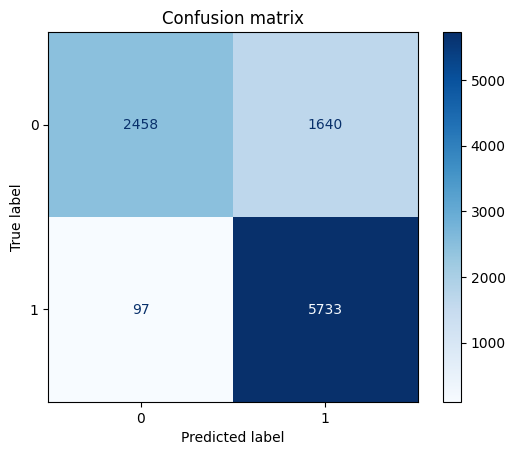

In [40]:
# Matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

El modelo logró identificar correctamente 5623 noticias falsas, lo que indica que tiene una alta efectividad en esta categoría. Además, solo 207 noticias falsas fueron clasificadas erróneamente como reales, lo que demuestra que el modelo tiene una tasa baja de falsos negativos. Por otro lado, uno de los problemas principales que se evidencian en la matriz es la cantidad de 1423 noticias reales que fueron clasificadas como falsas. Este alto número de falsos positivos puede indicar que el modelo es demasiado estricto al momento de detectar noticias falsas, lo que podría llevar a etiquetar mal noticias verdaderas como falsas. Por ultimo, 2675 noticias reales fueron correctamente clasificadas, lo que muestra que el modelo también tiene cierta capacidad para identificar noticias legítimas, aunque en menor medida comparado con su precisión en detectar noticias falsas.

# 6. Resultados

### 6.1 Modelo XGBoost

 En este caso, los resultados obtenidos muestran que este modelo ofrece una precisión alta en la clasificación de los datos. Su capacidad para manejar características complejas y aprender de errores previos lo hace una opción fuerte para este tipo de problema. 
 
 el 0 y 1 en los parentesis representa a la clase a la que pertenecen los resultados.

     - Precisión: 0.97 (0), 0.90 (1)

     - Recall: 0.85 (0), 0.98 (1)

     - F1-Score: 0.91 (0), 0.94 (1)

     Exactitud general: 0.93

 La matriz de confusión indica un bajo número de falsos negativos y falsos positivos, lo que sugiere un equilibrio adecuado entre precisión y recall. Es un modelo sólido con una capacidad predictiva muy alta, especialmente útil en situaciones donde la detección de falsos positivos y negativos es crítica.

### 6.2 Modelo Random Forest

 Es un modelo que ofrece buenos resultados con menor riesgo de sesgo en comparación con otros modelos individuales.

    - Precisión: 0.95 (0), 0.90 (1)

    - Recall: 0.85 (clase 0), 0.97 (1)

    - F1-Score: 0.90 (0), 0.94 (1)

    Exactitud general: 0.92

    La matriz de confusión muestra un buen desempeño con pocos errores de clasificación, aunque presenta un ligero aumento en los falsos positivos en comparación con XGBoost. Sin embargo, sigue siendo un modelo altamente confiable para la clasificación de datos con estructuras complejas.

### 6.3 Modelo Naive Bayes

    Este modelo sirve para problemas de clasificación de texto debido a su rapidez y bajo consumo de recursos computacionales. A pesar de esto, su implementación de independencia entre características puede afectar la precisión en algunos casos.

    - Precisión: 0.93 (0), 0.80 (1)

    - Recall: 0.65 (0), 0.96 (1)

    - F1-Score: 0.77 (0), 0.87 (1)

    Exactitud general: 0.84

    Este modelo muestra un rendimiento inferior en comparación con XGBoost y Random Forest, principalmente debido a su menor capacidad para capturar relaciones complejas en los datos. Se observa un alto número de falsos positivos, lo que sugiere que el modelo tiende a sobreestimar la clasificación de la clase 1. Si bien es útil por su eficiencia computacional, no es la mejor opción para este problema en particular.

### 6.4 Mejor modelo de clasificación de noticas falsas

Tras evaluar los tres modelos implementados XGBoost, Random Forest y Naive Bayes, se ha determinado que el mejor modelo es XGBoost. Esto se debe a que obtuvo los mejores resultados en términos de precisión, recall y F1-score. XGBoost logró una precisión del 97% para la clase 0 y 90% para la clase 1, con un recall del 85% y 98%, respectivamente. Esto indica que no solo clasifica correctamente la mayoría de los casos, sino que también detecta con mayor eficacia las noticias falsas. Además, su F1-score de 0.93 es superior al de los otros modelos, lo que demuestra un mejor equilibrio entre precisión y recall.

Otro punto importante es la matriz de confusión, donde XGBoost presenta menos errores de clasificación en comparación con Random Forest y Naive Bayes, reduciendo la cantidad de falsos positivos y falsos negativos. Naive Bayes, por otro lado, mostró un rendimiento inferior con un F1-score más bajo y un mayor número de errores, lo que lo hace menos adecuado para esta tarea.

# 7. Trabajo en equipo

## Roles y tareas
### Javier Barrera (Líder de proyecto, líder de datos)

Horas dedicadas: 15 horas
Algoritmos trabajados: Regresión logística y XGBoost

- Definición de fechas y horas de reunión
- Fechas límite para las actividades
- Verificación y manejo de las tareas 
- Preprocesamiento y análisis de datos
- Desarrollo de un modelo de clasificación 

### Julian Rolon (Líder de datos)

Horas dedicadas: 14 horas
Algoritmos trabajados: RandomForest

- Gestión de los datos y preprocesamiento
- Asignación de las tareas sobre datos
- Realizar la entrega de los datos en el repositorio
- Preprocesamiento y análisis de datos
- Desarrollo de un modelo de clasificación 

### Camilos Reyes (Líder de analítica) 

Horas dedicadas: 13 horas
Algoritmos trabajados: Naive-Bayes

- Revisión de la entrega con estándares de calidad
- Propuesta del modelo con las restricciones existentes
- Preprocesamiento y análisis de datos
- Desarrollo de un modelo de clasificación 

## Distribución de puntos 

| Integrante | Puntos |
| - | - |
| Javier Barrera | 34 |
| Julian Rolon | 33 |
| Camilo Reyes | 33 |

## Puntos a mejorar

- Realizar reuniones diarias o cada 3 días para avanzar en el proyecto.
- En caso tal de que no se pueda realizar algo avisar con tiempo. No hacer trabajos de otros.
- Utilizar un tablero Kanban para implementar Agile. 
- Participación proactiva en las actividades propuestas en el grupo.
- Estar al tanto de lo que esta realizando cada integrante del grupo.


## Uso de ChatGPT

En general se utilizo cuando no sabíamos que hacer. Hubo puntos durante la realización del proyecto en el cual ninguno de los integrantes sabia que era lo que se tenia que hacer. Una vez llegábamos a este punto le pasábamos el contexto del proyecto y en donde estábamos atascados, y ChatGPT procedia a darnos posibles soluciones, probábamos todas y nos quedamos con las mejores. Esto ocurrió aproximadamente 3 veces al realizar la creación de los modelos, para la primera fase del proyecto se usaron los notebooks de practica. Además, se utilizó DeepSeek para tareas menos complejas como manipulación de dataframes en general.

